<a href="https://colab.research.google.com/github/memo-math/Proyecto-Final-CienciadeDatos-CF/blob/main/XG_limpieza_analisis_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga del dataset y primeras transformaciones

En este notebook empezaremos a limpiar, transformar y entender nuestro dataset para ir preparando los datos para la creación del modelo.

In [ ]:
#empecemos importando las librerías que vamos a necesitar
!pip install mplsoccer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from mplsoccer import Pitch
from mplsoccer import VerticalPitch
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#carguemos el dataset
all_shots = pd.read_csv('shots_carga.csv')

In [3]:
all_shots.columns

Index(['Unnamed: 0', 'period', 'minute', 'location', 'under_pressure',
       'player_name', 'pattern_of_play', 'team', 'player_position',
       'statsbomb_xg', 'technique', 'body_part', 'tipe', 'outcome',
       'first_time'],
      dtype='object')

Removamos la columna `Unnamed: 0` y cambiemos el tipo de la columna `location`

In [4]:
all_shots=all_shots.drop('Unnamed: 0', axis=1)

In [5]:
all_shots['location']=all_shots['location'].apply(ast.literal_eval) #al cargar el dataframe location se volvio tipo str, la estamos volviendo a su valor original list

In [6]:
all_shots.head()

,period,minute,location,under_pressure,player_name,pattern_of_play,team,player_position,statsbomb_xg,technique,body_part,tipe,outcome,first_time
0,1,1,"[100.6, 54.6]",NaN,Stine Larsen,From Keeper,Aston Villa,Left Center Forward,0.037459,Normal,Left Foot,Open Play,Blocked,False
1,1,5,"[109.4, 43.0]",NaN,Vivianne Miedema,From Corner,Arsenal WFC,Left Wing,0.026655,Normal,Head,Open Play,Wayward,False
2,1,6,"[95.6, 38.9]",NaN,Jill Roord,From Throw In,Arsenal WFC,Left Center Midfield,0.034884,Normal,Right Foot,Open Play,Blocked,False
3,1,10,"[95.6, 44.6]",NaN,Bethany Mead,From Throw In,Arsenal WFC,Center Forward,0.020819,Normal,Right Foot,Open Play,Off T,False
4,1,14,"[111.0, 33.7]",NaN,Leah Williamson,From Corner,Arsenal WFC,Right Center Back,0.112665,Half Volley,Left Foot,Open Play,Off T,True


De acuerdo a la documentación y a lo analizado en el notebook anterior debemos transformar la columna `under_pressure`, cambiando los valores NaN por un $0$
el cual interpretaremos como un False


In [7]:
all_shots['under_pressure'] = all_shots['under_pressure'].replace(np.nan, 0)

In [8]:
all_shots['under_pressure'].value_counts()

0.0    7591
1.0    1771
Name: under_pressure, dtype: int64

De la columna `outcome` lo único que nos interesa es si el resultado es gol o no, entonces transformemos los valores a $0$ y $1$. Tomando el valor de $1$ como gol y $0$ como tiro fallado

In [9]:
all_shots['outcome'].value_counts()

Off T               2923
Blocked             2313
Saved               2275
Goal                1064
Wayward              482
Post                 217
Saved Off Target      62
Saved to Post         26
Name: outcome, dtype: int64

In [10]:
goal = [1 if x == 'Goal' else 0 for x in all_shots['outcome']]

In [11]:
all_shots['goal']=goal

In [12]:
all_shots['goal'].value_counts()

0    8298
1    1064
Name: goal, dtype: int64

In [13]:
#ahora podemos borrar la columna outcome
all_shots = all_shots.drop('outcome', axis=1)

Ahora vamos a crear dos columnas más una `location_x `con la coordenada x de `location`, y otra similar llamada `location_y`. Esto con la finalidad de realizar las gráficas un poco más fácil

In [14]:
location_x=[]
location_y=[]
for fila in range(all_shots.shape[0]):
  location_x.append(all_shots['location'][fila][0])
  location_y.append(all_shots['location'][fila][1])

In [15]:
all_shots['location_x'] = location_x
all_shots['location_y'] = location_y

Hasta el momento ya tenemos un dataset que puede resultar muy interesante para un aficionado al futbol. Por ejemplo, tomemos un equipo de la liga de Estados Unidos y visualicemos todos los tiros que realizo en la temporada que tenemos disponible.

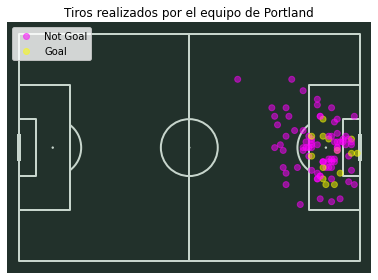

In [17]:
#tomemos al equipo de los Portland Thorns
Portland=all_shots[all_shots['team']=='Portland Thorns']

pitch = Pitch(pitch_color='#22312b', line_color='#c7d5cc')  
fig, ax = pitch.draw()
scatter=plt.scatter(Portland['location_x'], Portland['location_y'], c=Portland['goal'], cmap='spring', label=Portland['goal'], alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=('Not Goal', 'Goal'), loc='upper left')
plt.title('Tiros realizados por el equipo de Portland')
plt.show()

## Entendiendo nuestros datos y sacando nuevas features

Lo primero que podemos hacer es graficar el total de tiros y su resultado

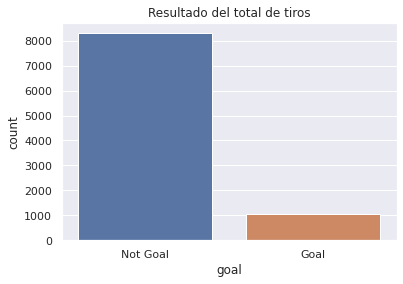

In [18]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="goal", data=all_shots)
plt.title('Resultado del total de tiros')
plt.xticks([0, 1], ['Not Goal', 'Goal'])
plt.show()

Podemos ver que los goles son resultados escasos de los tiros, algo que era de esperarse de acuerdo a la experiencia de ver partidos de fútbol.

La siguiente pregunta natural es en qué sectores del campo es donde suceden la mayor parte de tiros, y la mayor parte de los goles

In [19]:
flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 10 colors", ['#e3aca7', '#c03a1d'], N=10)

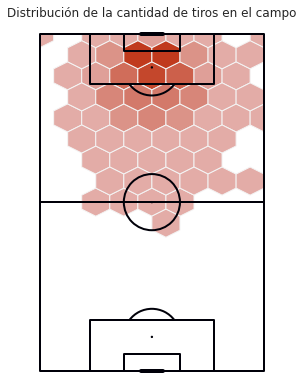

In [20]:
pitch = VerticalPitch(line_color='#000009', line_zorder=2, pitch_color='white')
fig, ax = pitch.draw(figsize=(4.4, 6.4))
hexmap = pitch.hexbin(all_shots['location_x'], all_shots['location_y'], ax=ax, edgecolors='#f4f4f4',
                      gridsize=(8, 8), cmap=flamingo_cmap)
plt.title('Distribución de la cantidad de tiros en el campo')
plt.show()

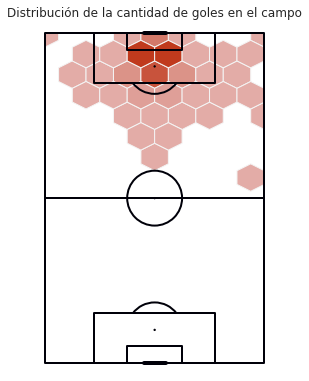

In [21]:
goals = all_shots[all_shots['goal']==1]

pitch = VerticalPitch(line_color='#000009', line_zorder=2, pitch_color='white')
fig, ax = pitch.draw(figsize=(4.4, 6.4))
hexmap = pitch.hexbin(goals['location_x'], goals['location_y'], ax=ax, edgecolors='#f4f4f4',
                      gridsize=(8, 8), cmap=flamingo_cmap)
plt.title('Distribución de la cantidad de goles en el campo')
plt.show()

Podemos observar que se realizan más tiros, y más gol, es entre más cerca se encuentre la jugada de la portería. Esto nos da una intuición de que la distancia debería ser un aspecto clave para nuestro modelo.

Procedamos a calcular la distancia de cada uno de los tiros al centro de la portería, para saber las coordenadas de dicho puntos nos apoyamos de la documentación y concluimos que el centro de la portería se encuentra en las coordenadas $(120, 40)$

In [22]:
def distance_two_points(point_one, point_two = (120, 40)):
  return np.linalg.norm(np.array(point_one)-np.array(point_two))

In [23]:
all_shots['distance'] = all_shots['location'].apply(distance_two_points)

In [24]:
all_shots.head()

,period,minute,location,under_pressure,player_name,pattern_of_play,team,player_position,statsbomb_xg,technique,body_part,tipe,first_time,goal,location_x,location_y,distance
0,1,1,"[100.6, 54.6]",0.0,Stine Larsen,From Keeper,Aston Villa,Left Center Forward,0.037459,Normal,Left Foot,Open Play,False,0,100.6,54.6,24.280033
1,1,5,"[109.4, 43.0]",0.0,Vivianne Miedema,From Corner,Arsenal WFC,Left Wing,0.026655,Normal,Head,Open Play,False,0,109.4,43.0,11.016351
2,1,6,"[95.6, 38.9]",0.0,Jill Roord,From Throw In,Arsenal WFC,Left Center Midfield,0.034884,Normal,Right Foot,Open Play,False,0,95.6,38.9,24.424782
3,1,10,"[95.6, 44.6]",0.0,Bethany Mead,From Throw In,Arsenal WFC,Center Forward,0.020819,Normal,Right Foot,Open Play,False,0,95.6,44.6,24.829821
4,1,14,"[111.0, 33.7]",0.0,Leah Williamson,From Corner,Arsenal WFC,Right Center Back,0.112665,Half Volley,Left Foot,Open Play,True,0,111.0,33.7,10.985900


Procedamos a ver como influye la distancia en la distribución de los tiros y los goles

In [25]:
goals = all_shots[all_shots['goal']==1]

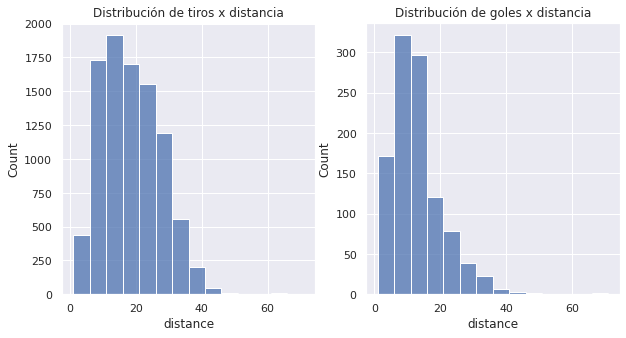

In [26]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
sns.histplot(ax=axes[0], x="distance", data=all_shots, binwidth=5)
axes[0].set_title('Distribución de tiros x distancia')
sns.histplot(ax=axes[1], x="distance", data=goals, binwidth=5)
axes[1].set_title('Distribución de goles x distancia')
plt.show()

Se puede observar a partir de estas gráficas que:
 * La mayoría de tiros ocurre de las 5 a las 20 yardas.
 * Es díficil que se pueda tirar dentro de las primeras 5 yardas
 * La mayoría de goles se produce de las 5 a las 15 yardas

De acuero a diversas fuentes una de las features relevantes aparte de la distancia es el ángulo de tiro.

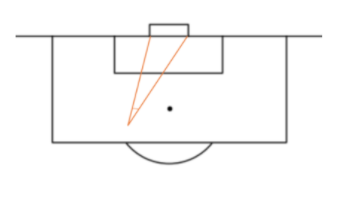

Para poder obtener este valor existen algunas fórmulas preestablecidas. Sin embargo, al usarlas para este dataset se obtienen resultados inconsistentes, por lo que podemos recurrir a la ley de cosenos

Simplemente despejando el valor del ángulo de la ley de cosenos encontramos:

$$angulo = arccos \left( \frac{a^2 + b^2 - 64}{2ab} \right)$$

donde $a$ es la distancia del punto de tiro a uno de los postes, $b$ es igual la distancia pero al poste restante y $64$ es el cuadrado del ancho de la porteria en yardas

In [27]:
def angle(point):
  ladouno = distance_two_points(point, (120, 36)) #(120, 36) coordenadas de un poste de la porteria
  ladodos = distance_two_points(point, (120, 44)) #(120, 44) coordenas del otro post
  return np.arccos((ladouno**2 + ladodos**2 - 64) / (2*ladouno*ladodos))

In [28]:
all_shots['angle']=all_shots['location'].apply(angle)

In [29]:
goals = all_shots[all_shots['goal']==1]

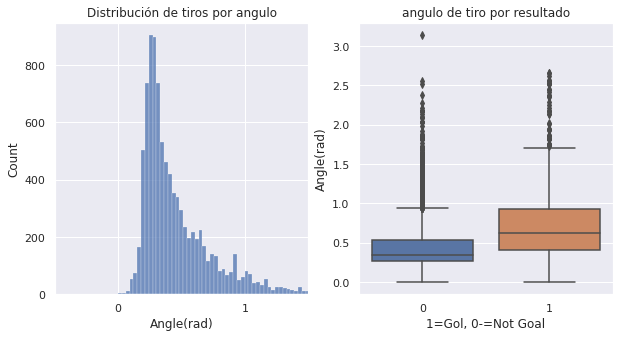

In [30]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
sns.histplot(ax=axes[0], x="angle", data=all_shots)
axes[0].set_title('Distribución de tiros por angulo')
axes[0].set(xlabel='Angle(rad)', ylabel='Count')
sns.boxplot(ax=axes[1], x='goal', y="angle", data=all_shots)
axes[1].set_title('angulo de tiro por resultado')
axes[1].set(xlabel='1=Gol, 0-=Not Goal', ylabel='Angle(rad)')
plt.show()

Podemos notar que se han marcado goles a pesar de no tener ángulo de tiro, un ejemplo de esto podrían ser los goles olímpicos. 

También se puede observar que la mediana de los ángulo de los tiros fallados es menor a la mediana de ángulos de los tiros que terminan en gol.

Procedamos a ver la distribución de tiros a través del tiempo de juego

In [31]:
goals = all_shots[all_shots['goal']==1]

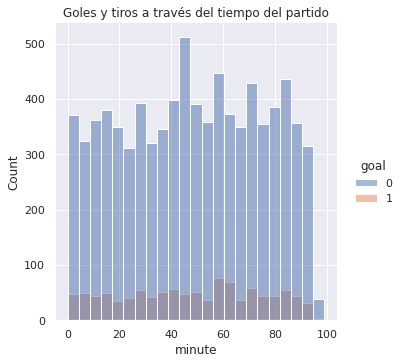

In [32]:
sns.displot(data=all_shots, x="minute", hue="goal")
plt.title('Goles y tiros a través del tiempo del partido')
plt.show()

Uno se esperaba que cerca del final del partido fuera donde más tiros se efectuaran debido a intentar ganar o empatar 'de último minuto', cosa que no sucede para los datos analizados de estos partidos

## Entendiendo las variables categóricas

Empecemos por analizar que tanto influye la parte del cuerpo con la que se realiza el tiro.

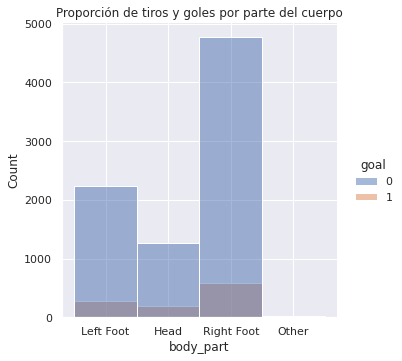

In [33]:
sns.displot(data=all_shots, x="body_part", hue="goal")
plt.title('Proporción de tiros y goles por parte del cuerpo')
plt.show()

Podemos observar que es difícil que se remate con una parte del cuerpo que no sean los pies o la cabeza, de ahí los 'remates con la cabeza' son los que menos suceden y como era de esperarse la mayoría de los tiros se hacen con el pie derecho.

La variable `tipe` especifica el tipo de tiro, de estos dos valores son muy relavantes:  `Penalty` y `Free Kick` que generalmente son consideradas dos situaciones de peligro. 

In [34]:
all_shots[all_shots['tipe']=='Penalty']['goal'].value_counts()

1    65
0    24
Name: goal, dtype: int64

Así la probabilidad de marcar un gol dado que el tipo de tiro es un penal es de

$$P(gol) = \frac{65}{65+24}=0.73$$

Por lo que dado un penal, existe una alta probabilidad de que termine en gol, lo cual confirma algo obvio.

In [35]:
all_shots[all_shots['tipe']=='Free Kick']['goal'].value_counts()

0    259
1     26
Name: goal, dtype: int64

La probabilidad de marcar un gol dado que el tiro proviene directo de un tiro libre es de

$$P(gol) = \frac{26}{26+259}=0.09$$

Lo cual quiere decir que es difícil marcar desde un tiro libre.

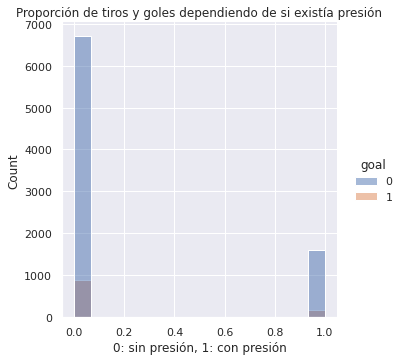

In [36]:
ax=sns.displot(data=all_shots, x="under_pressure", hue="goal")
plt.title('Proporción de tiros y goles dependiendo de si existía presión')
ax.set(xlabel='0: sin presión, 1: con presión')
plt.show()

Podemos observar que no hay una diferencia significativa entre las proporciones de tiros fallados con los goles dependiendo si existe presión o no a la hora del tiro.

Ahora visualicemos los tiros y goles por el patrón de la jugada y luego por la técnica de tiro

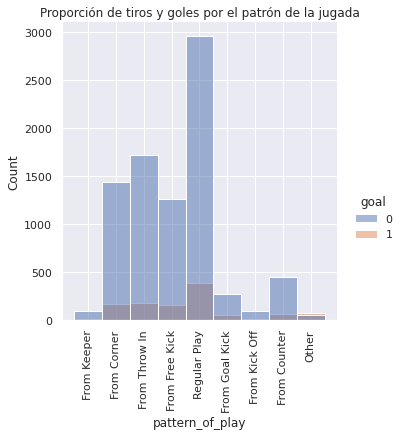

In [38]:
sns.displot(data=all_shots, x="pattern_of_play", hue="goal")
plt.title('Proporción de tiros y goles por el patrón de la jugada')
plt.xticks(rotation=90)
plt.show()

Podemos ver en el patrón de jugada donde hay más goles que tiros es en 'Other' aunque son muy pocos tiros los que provienen de este patrón.

Por último observemos la distribución de tiros y goles dependiendo de si el tiro fue realizado de primer toque o no

In [40]:
all_shots['first_time'] = all_shots['first_time'].replace({True: 1, False: 0})

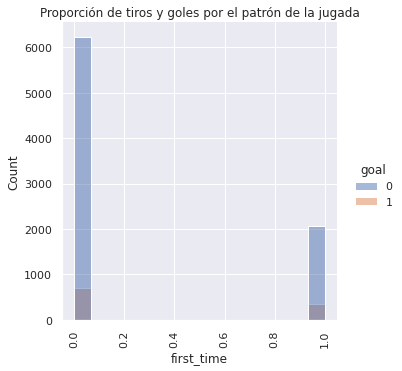

In [41]:
sns.displot(data=all_shots, x="first_time", hue="goal")
plt.title('Proporción de tiros y goles por el patrón de la jugada')
plt.xticks(rotation=90)
plt.show()

Una vez que hemos realizado visualizaciones, transformaciones y el análisis podemos pasar a la realización de nuestro modelo para los goles esperados. Así que guardemos nuestro dataset para poder usarlo en nuestro siguiente notebook

In [42]:
all_shots.to_csv('shots_limpieza.csv')